In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

FILE_PATH = "Main File/TSMOM/Data/target_vol = 0.4/pnl_k_h_0.4.csv"


df  = pd.read_csv(FILE_PATH).drop(['Unnamed: 0'], axis = 1).sort_values(by = ['k','h']).reset_index(drop = True)

In [57]:
df.shape

(49, 1030)

In [73]:
def winrate(pnl, signal,h):
    win_count = lose_count = 0
    company = pnl.columns
    for oo in company:
        flag_h = 0
        for x in range(0,pnl.shape[1]):
            if flag_h != 0:
                flag_h = flag_h - 1
            if signal[oo].iloc[x] == 1:
                if pnl[oo].iloc[x + h -1] > 0: win_count = win_count + 1
                elif pnl[oo].iloc[x + h -1] < 0: lose_count = lose_count + 1
                flag_h = h - 1
            elif signal[oo].iloc[x] == -1:
                if pnl[oo].iloc[x + h -1] < 0: win_count = win_count + 1
                elif pnl[oo].iloc[x + h -1] > 0: lose_count = lose_count + 1
                flag_h = h - 1
    return win_count / (win_count + lose_count) *100

In [ ]:
for k in ["01","03","05","10","15","20","40"]:
    for h in ["01","03","05","10","15","20","40"]:
        pnl = pd.read_csv("Main File/TSMOM/Data/target_vol = 0.3/pnl/pnl (k = "+ str(k)+ ", h = " + str(h) + ").csv").set_index('Date')

        signal = pd.read_csv("Main File/TSMOM/Data/target_vol = 0.3/signal/signal (k = "+ str(k)+ ", h = " + str(h) + ").csv").set_index('Date')

        temp = winrate(pnl,signal, int(h))
        try:
            temp2 = [k,h,temp]
            stats.loc[len(stats.index)] = temp2
        except:
            stats = pd.DataFrame(columns = ["k","h","winrate"])
            temp2 = [k,h,temp]
            stats.loc[len(stats.index)] = temp2



In [60]:
def plotting_k_analyst(k):
    # remove sort_value.... for full graph
    cummulative_return = (df[df['k'] == k].iloc[:,2:] + 1).cumprod(axis = 1).reset_index(drop= True).sort_values(by = ['2023-12-29 00:00:00+01:00'], ascending = False)[:10]

    fig, ax = plt.subplots(figsize=(24, 12))
    for x in range(0,30):
        try:
            ax.plot(cummulative_return.loc[x], label = "h = " +str(x +1))
            ax.legend()
        except: pass
    plt.title('Cummulative Return when k = ' + str(k))

    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.show()

    return


def plotting_h_analyst(h):
    
    cummulative_return = (df[df['h'] == h].iloc[:,2:] + 1).cumprod(axis = 1).reset_index(drop= True).sort_values(by = ['2023-12-29 00:00:00+01:00'], ascending = False)[1:5]

    fig, ax = plt.subplots(figsize=(24, 12))
    for x in range(0,30):
        try:
            ax.plot(cummulative_return.loc[x], label = "k = " +str(x +1))
            ax.legend()
        except: pass
    plt.title('Cummulative Return when h = ' + str(h))

    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.show()

    return

### Adding EU_stock for benchmark

In [61]:
import yfinance as yf

tolerance = 0.
k = 1
h = 1

# rule = 'BME'

time_range = '5y'

start_time = '2019-12-31'
end_time = '2024-01-01'

# Vol scaling
vol_flag = 0                  # Set flag to 1 for vol targeting
if vol_flag == 1:
    target_vol = 0.4 # Can be changed
else:
    target_vol = 'no target vol'


In [62]:
def EU_Index_data():

    stock_list =['^STOXX50E']
    futures = pd.DataFrame(columns= stock_list)

    time_index = list(yf.Ticker(stock_list[0]).history(period = time_range,start = start_time, end = end_time).index)
    flag = 0

    for symbol in stock_list:
        df = yf.Ticker(symbol).history(period = time_range, start = start_time, end = end_time)
        df = pd.DataFrame(df['Close'])
        i = 0
        daily_return = []
        for k in df['Close']:
            if i != 0:
                daily_return.append(float((k-i)/i))
            else:
                daily_return.append(float(0))
            i = k
        if time_index != list(df.index): flag +=1
        try:
            futures[symbol] = daily_return
        except:
            print(symbol)
            print(len(daily_return)) # Check differnet time index
            while len(daily_return) < len(futures):
                daily_return.insert(0,np.nan)
            futures[symbol] = daily_return

    futures.index = time_index
    futures = futures.iloc[1:, :]


    # print(flag) # Check differnet time index

    futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d')
    futures.set_index('Date', inplace=True)

    return futures

In [63]:
EU_50 = EU_Index_data().transpose()

In [64]:
EU_50.mean(axis=1)/EU_50.std(axis=1, ddof = 1)* np.sqrt(252)

^STOXX50E    0.313778
dtype: float64

In [65]:
def cummulative_returning(data):
    return  (data.iloc[:,2:] + 1).cumprod(axis = 1).iloc[:,-1]

def annualise_return(data):
    return (1 + cummulative_returning(data))**(252/ (data.shape[1] - 2)) - 1

def sharpe_ratio(data):
    return (data.iloc[:,2:].mean(axis=1)/data.iloc[:,2:].std(axis=1, ddof = 1))* np.sqrt(252)

def maximum_drawdown(data):
    cumulative = (data.iloc[:,2:] + 1).cumprod(axis = 1)
    max_return = cumulative.cummax(axis = 1)
    return cumulative.sub(max_return).div(max_return).min(axis = 1)

def calmar_ratio(data):
    return annualise_return(data)/ -maximum_drawdown(data)

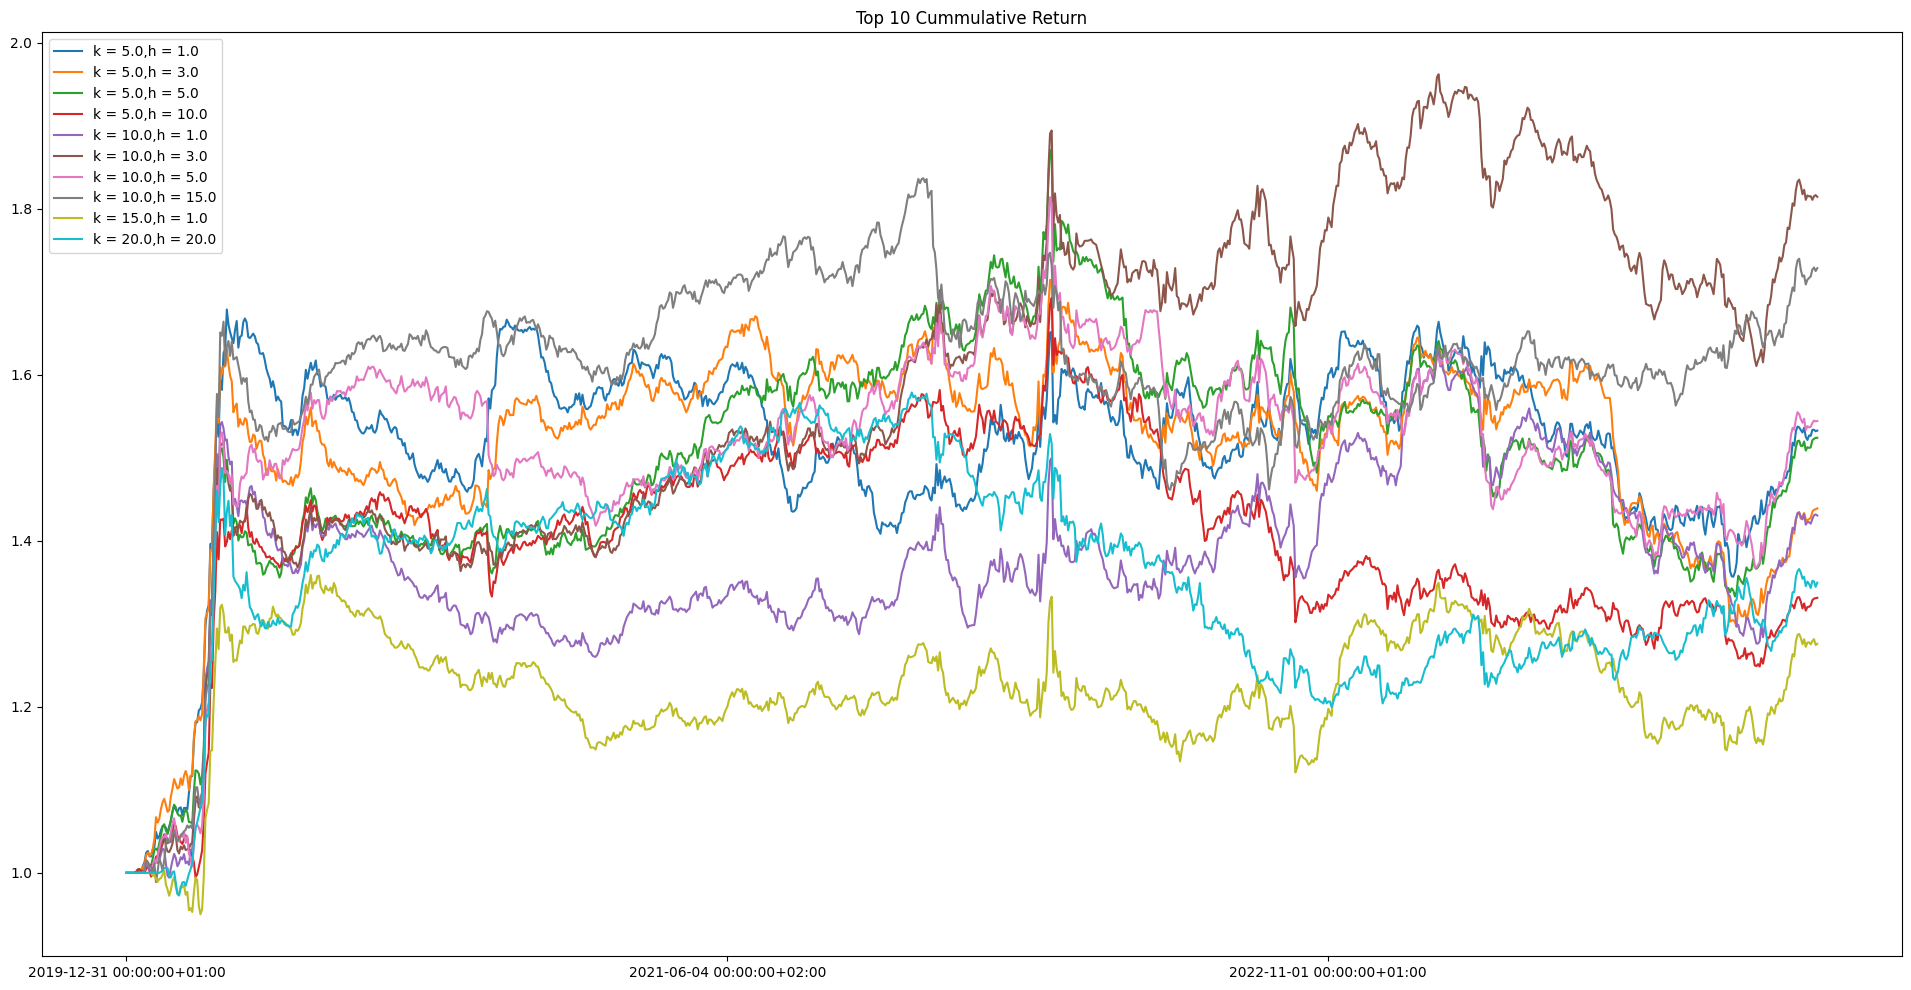

In [66]:
cummulative_return = (df.iloc[:,2:] + 1).cumprod(axis = 1).reset_index(drop= True).sort_values(by = ['2023-12-29 00:00:00+01:00'], ascending = False)[:10]

fig, ax = plt.subplots(figsize=(24, 12))
for x in range(0,64):
    try:
        ax.plot(cummulative_return.loc[x], label = "k = " +str(df.loc[x]['k']) + ",h = "+ str(df.loc[x]['h']))
        ax.legend()
    except: pass
plt.title('Top 10 Cummulative Return')

ax.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

In [67]:
cummulative_return = (df.iloc[:,2:] + 1).cumprod(axis = 1)

cummulative_return.columns = pd.to_datetime(cummulative_return.columns)

C:\Users\hungl\AppData\Local\Temp\ipykernel_14344\3310618497.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  cummulative_return.columns = pd.to_datetime(cummulative_return.columns)


C:\Users\hungl\AppData\Local\Temp\ipykernel_14344\1610080271.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  cummulative_return.columns = pd.to_datetime(cummulative_return.columns)


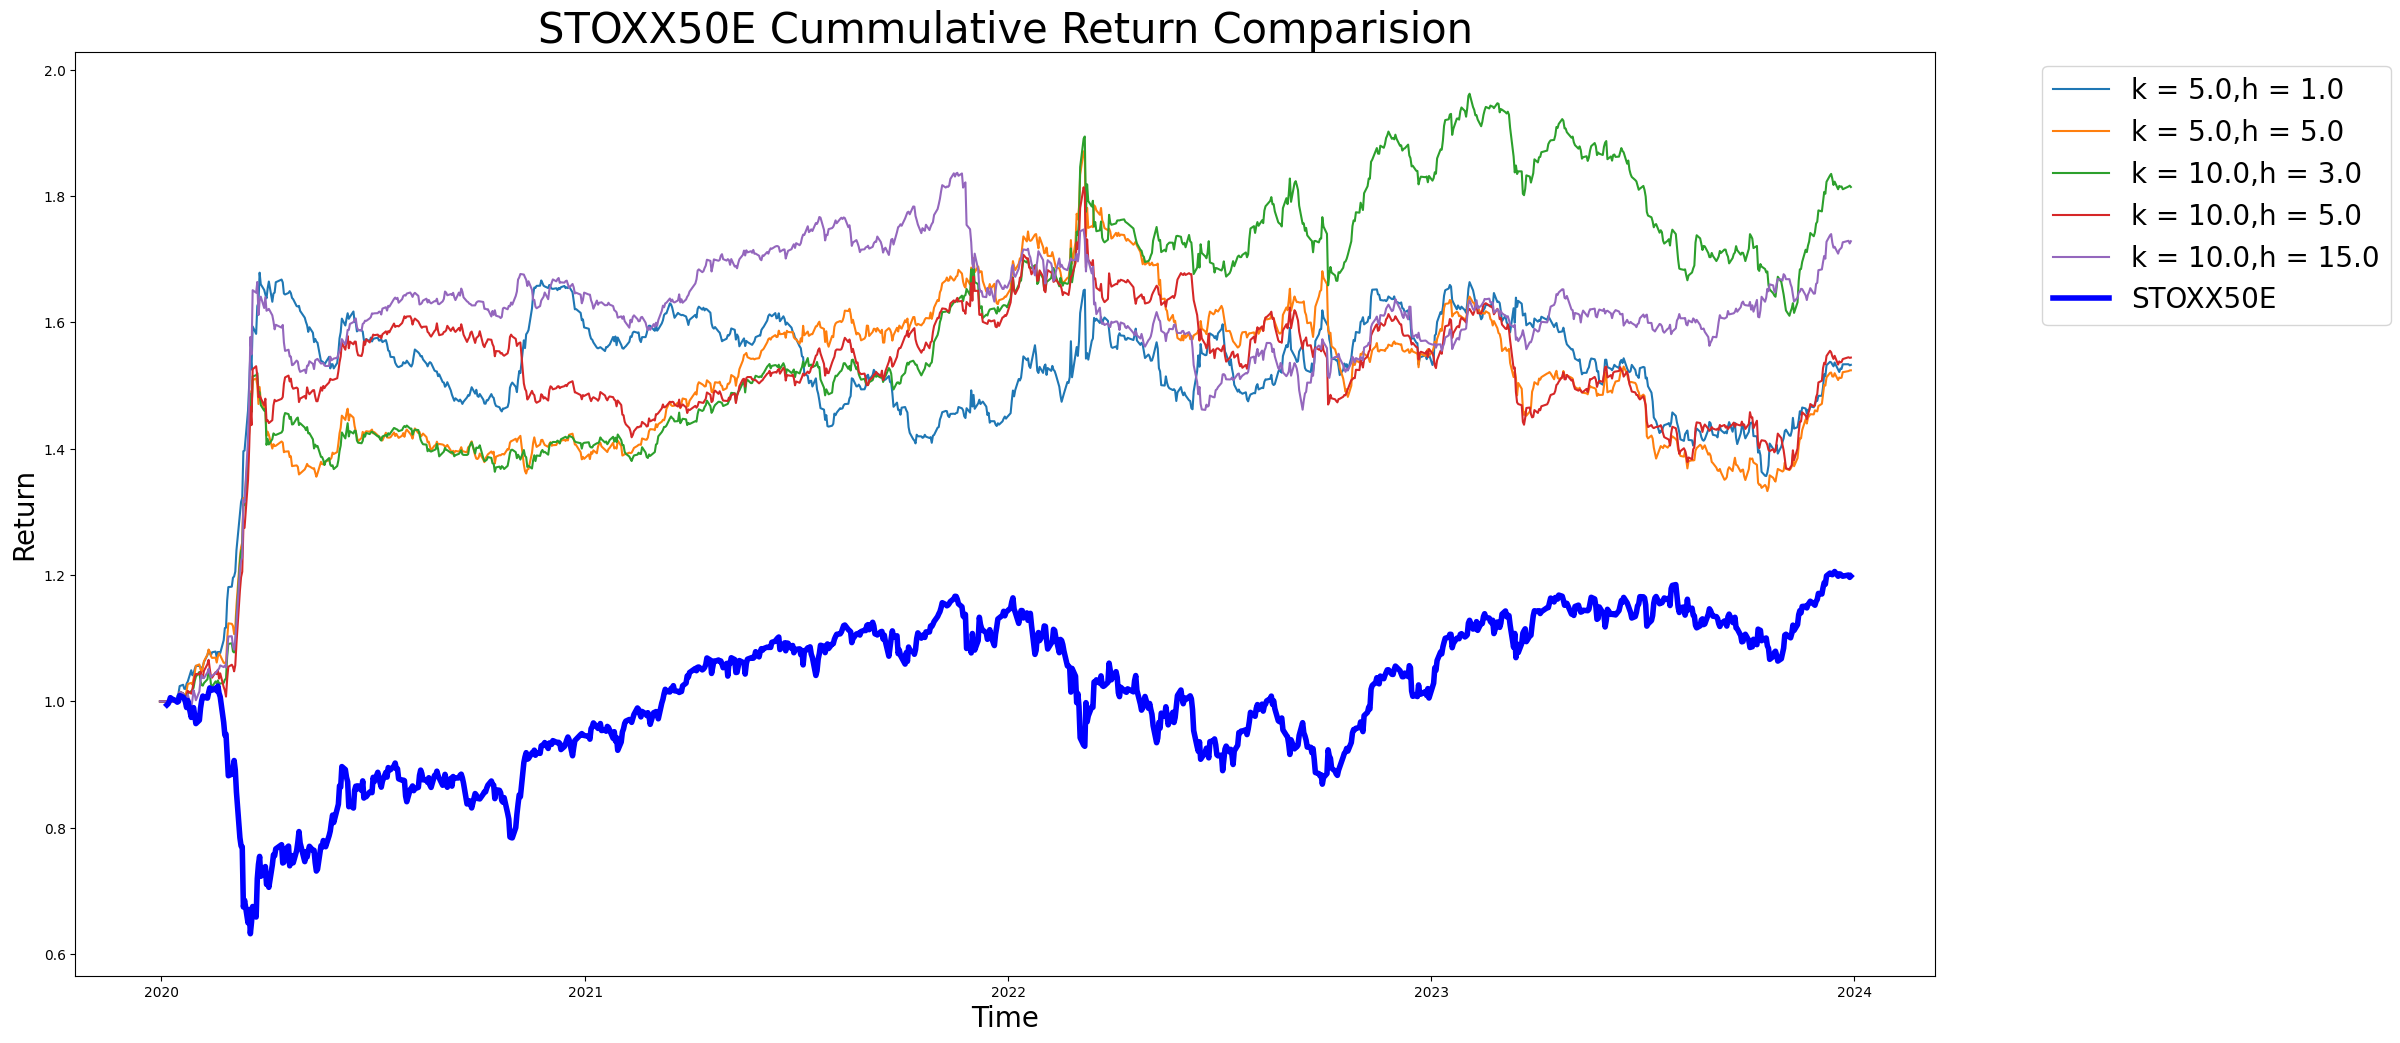

In [68]:
fig, ax = plt.subplots(figsize=(24, 12))

benchmark = (EU_50+1).cumprod(axis = 1).loc['^STOXX50E']

cummulative_return = (df.iloc[:,2:] + 1).cumprod(axis = 1).reset_index(drop= True).sort_values(by = ['2023-12-29 00:00:00+01:00'], ascending = False)[:5]

cummulative_return.columns = pd.to_datetime(cummulative_return.columns)

for x in range(0,64):
    try:
        ax.plot(cummulative_return.loc[x], label = "k = " +str(df.loc[x]['k']) + ",h = "+ str(df.loc[x]['h']))
        ax.legend()
    except: pass

ax.xaxis.set_major_locator(mdates.YearLocator())

ax.plot(benchmark, color = 'Blue', linewidth = 4., label = 'STOXX50E')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 20)

ax.set_xlabel("Time", fontsize = 20)
ax.set_ylabel("Return", fontsize = 20)


plt.title('STOXX50E Cummulative Return Comparision', fontsize = 30)
plt.show()


In [69]:
df_benchmark = pd.DataFrame()

df_benchmark['cum_return'] = (cummulative_returning(df) / float((EU_50+1).cumprod(axis = 1).iloc[:,-1]) - 1)*100
df_benchmark['annual_return'] = annualise_return(df)
df_benchmark['sharpe_ratio'] =  sharpe_ratio(df)
df_benchmark['max_drawdown'] = maximum_drawdown(df)
df_benchmark['calmar_ratio'] = calmar_ratio(df)

df_benchmark['k'] = df['k']
df_benchmark['h'] = df['h']

df_benchmark

C:\Users\hungl\AppData\Local\Temp\ipykernel_14344\1557032424.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_benchmark['cum_return'] = (cummulative_returning(df) / float((EU_50+1).cumprod(axis = 1).iloc[:,-1]) - 1)*100


,cum_return,annual_return,sharpe_ratio,max_drawdown,calmar_ratio,k,h
0,-4.402381,0.205791,0.326885,-0.327997,0.627420,1,1
1,-20.633644,0.178027,-0.061657,-0.182610,0.974907,1,3
2,-6.839890,0.201747,0.259793,-0.280464,0.719331,1,5
3,-40.865240,0.140327,-0.394354,-0.473657,0.296263,1,10
4,-62.345527,0.095586,-0.926169,-0.584688,0.163482,1,15
5,-60.113278,0.100502,-0.540679,-0.663326,0.151512,1,20
6,-48.292319,0.125471,-0.151105,-0.702445,0.178621,1,40
7,-7.678404,0.200345,0.251993,-0.364133,0.550199,3,1
8,-5.691185,0.203658,0.310082,-0.235288,0.865568,3,3
9,-3.605921,0.207104,0.340884,-0.362226,0.571753,3,5


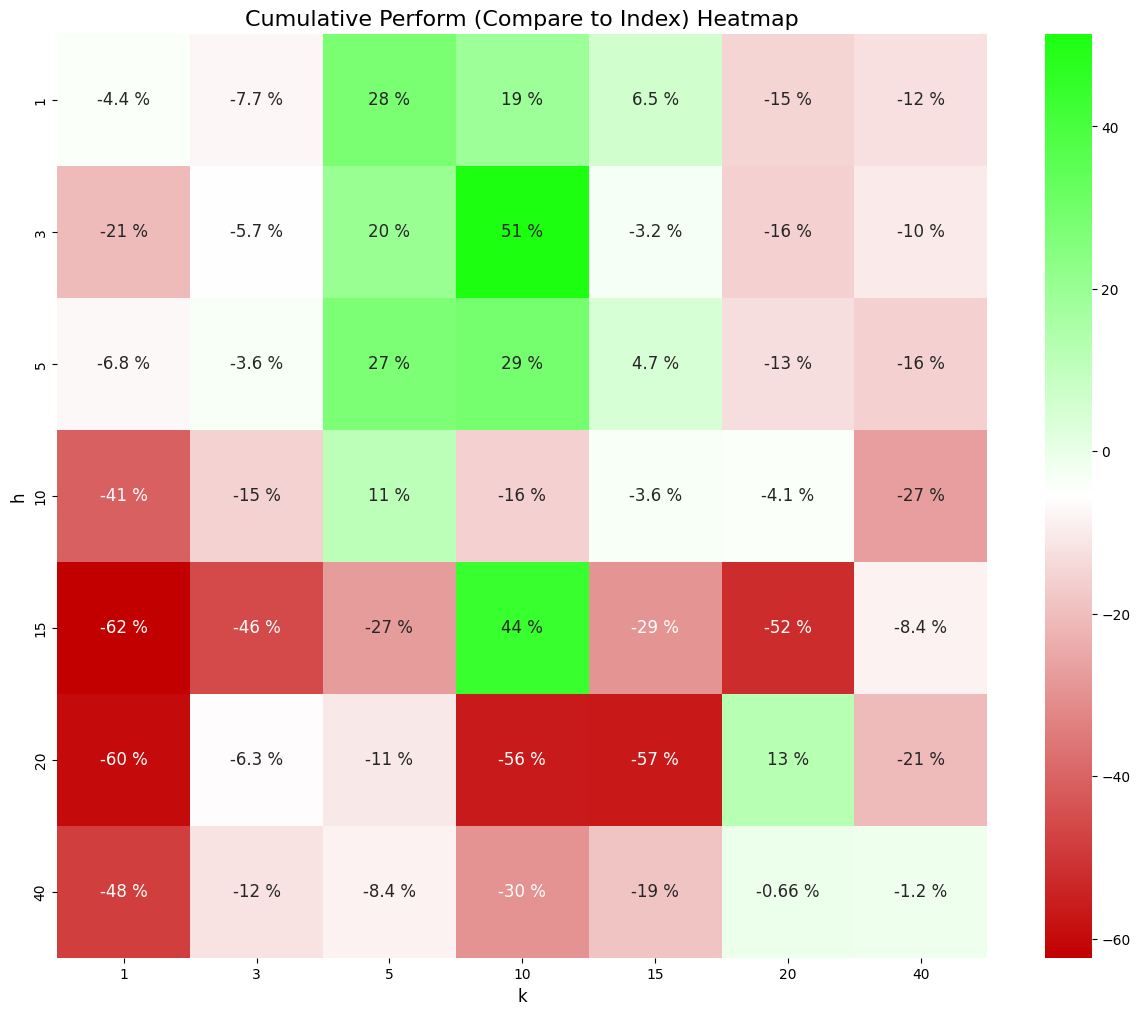

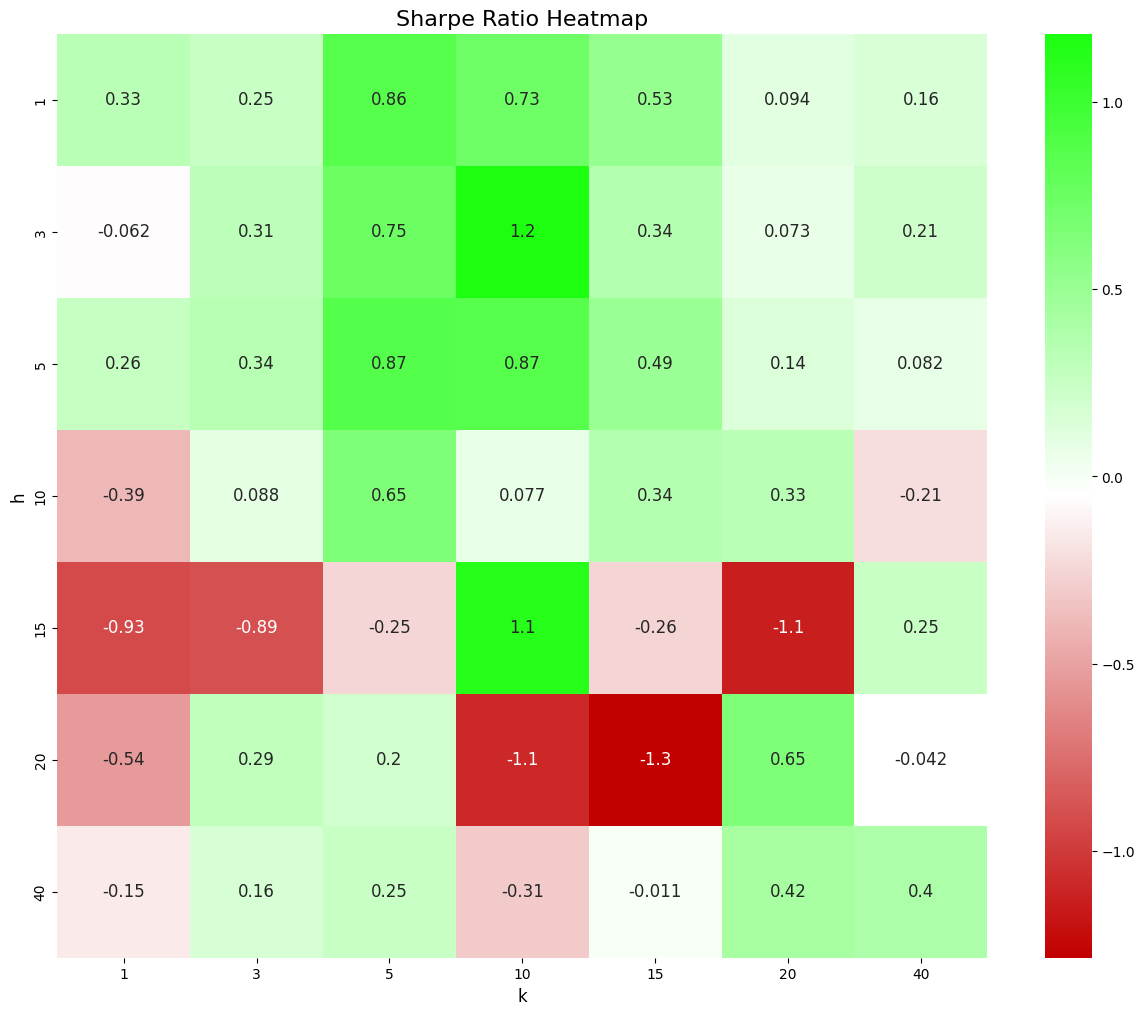

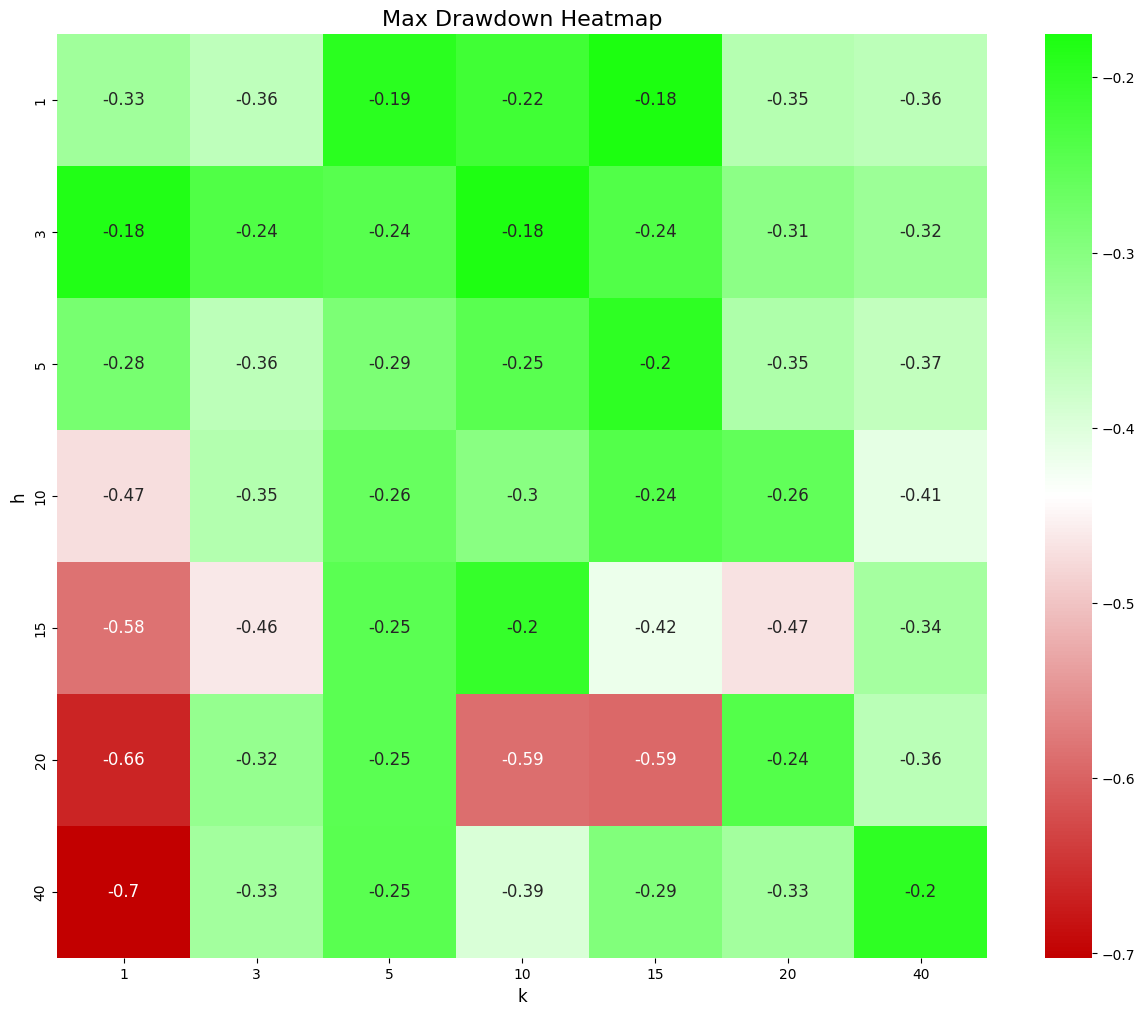

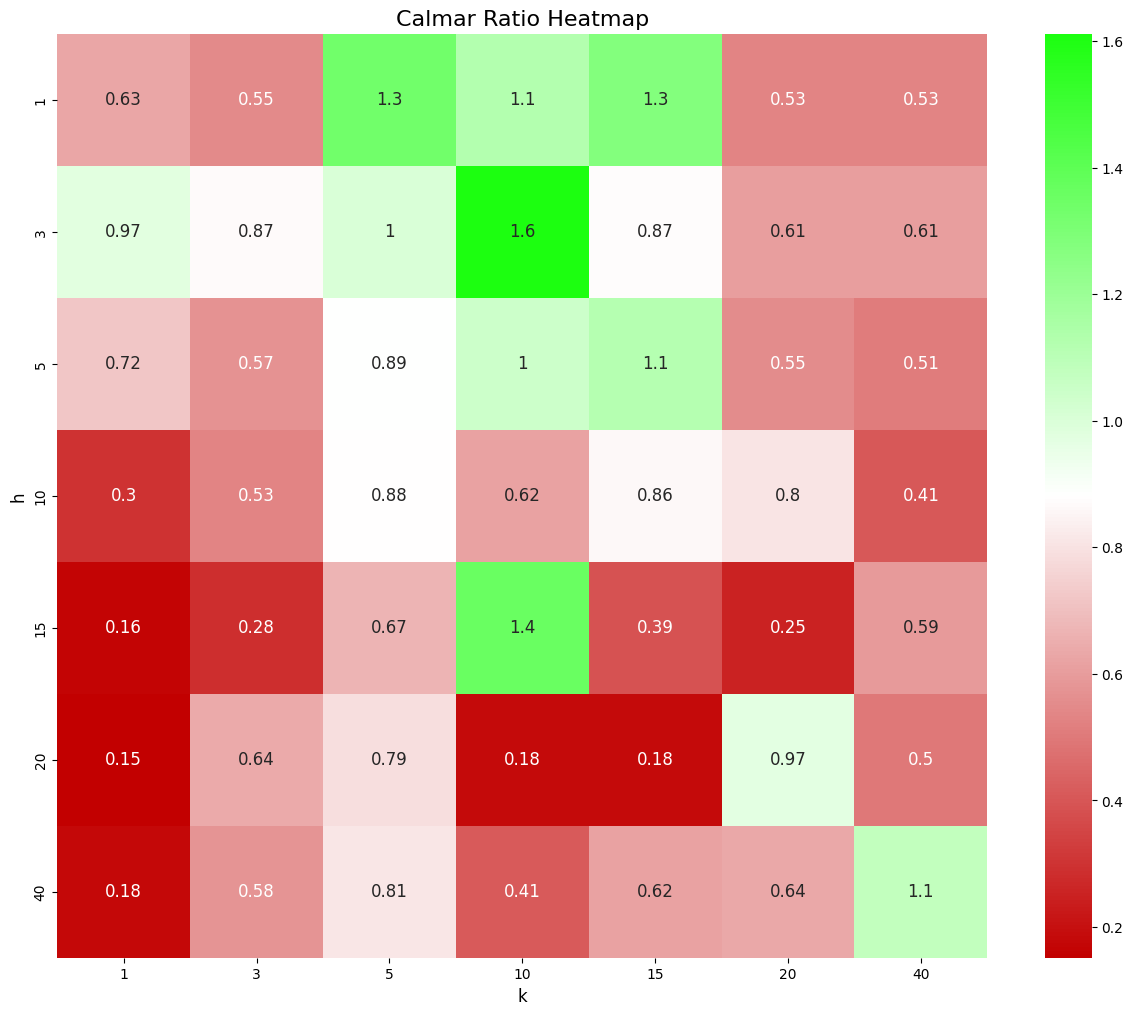

In [70]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

cum_return_df = df_benchmark.pivot(index = 'h', columns='k', values='cum_return')
annual_return_df = df_benchmark.pivot(index='h', columns='k', values='annual_return')
sharpe_ratio_df = df_benchmark.pivot(index='h', columns='k', values='sharpe_ratio')
max_drawdown_df = df_benchmark.pivot(index='h', columns='k', values='max_drawdown')
calmar_ratio_df = df_benchmark.pivot(index='h', columns='k', values='calmar_ratio')

# Define a function to create heatmaps
def create_heatmap(df, metric_name):

    colors = ["#C20000", "#FFFFFF","#1CFF10"]  # Define custom colors
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors) 
    
    plt.figure(figsize=(15, 12))  # Larger figure size for width and height
    ax = sns.heatmap(df, annot=True, cmap= custom_cmap,  # Adjust annotation size
                annot_kws = {'size': 12})  # Larger annotation size
    if "Cumulative" in metric_name:
        for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.title(f'{metric_name} Heatmap', fontsize=16)  # Larger title
    plt.xlabel('k', fontsize=12)  # Larger x-axis label
    plt.ylabel('h', fontsize=12)  # Larger y-axis label

    plt.show()

# Create heatmaps for each metric
create_heatmap(cum_return_df, 'Cumulative Perform (Compare to Index)')
create_heatmap(sharpe_ratio_df, 'Sharpe Ratio')
create_heatmap(max_drawdown_df, 'Max Drawdown')
create_heatmap(calmar_ratio_df, 'Calmar Ratio')

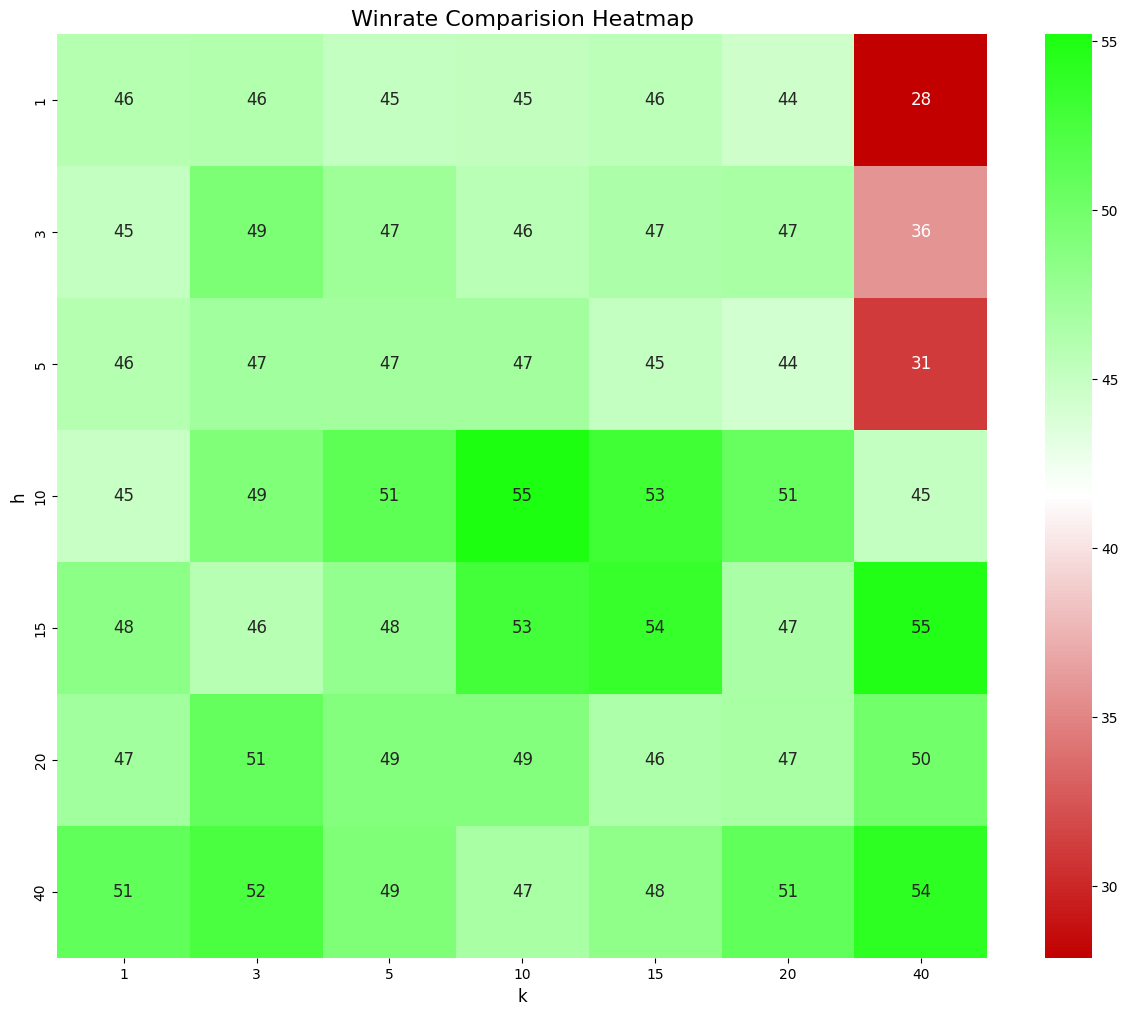

In [ ]:
winrate_ = stats.pivot(index = 'h', columns='k', values='winrate')
create_heatmap(winrate_, "Winrate Comparision")

* Các cặp (k,h) sẽ luôn outperform bất kể là target_vol như nào đi chăng nữa
* target_vol càng to -> cummulative return càng tốt nhưng calmar ratio sẽ nhỏ, và ngược lại
* Kết quả nằm ở khoảng giữa khi mà không có target_vol